In [1]:
from pymongo import MongoClient
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# trend_DB visualization

In [2]:
# Create an instance of MongoClient
mongo = MongoClient(port=27017)

In [3]:
# confirm that our new database was created
print(mongo.list_database_names())

['admin', 'autosaurus', 'classDB', 'config', 'epa', 'fruits_db', 'local', 'met', 'petsitly_marketing', 'project3', 'project3trend', 'uk_food']


In [4]:
# Create the database under 'project3trend'
trend_db = mongo['project3trend']

In [5]:
# Print collection names
print(trend_db.list_collection_names())

# Define the collection
trend_collection = trend_db['trend_data']

['trend_data']


In [6]:
# Define the aggregation pipeline
pipeline = [
    {"$group": {"_id": "$Year", "mass_shootings": {"$sum": "$Mass Shootings (Incidents)"}}},
    {"$sort": {"_id": 1}}]

In [7]:
# Execute the aggregation pipeline and convert the result to a DataFrame
result = trend_collection.aggregate(pipeline)
trend_df = pd.DataFrame(list(result))
trend_df.head()

,_id,mass_shootings
0,1966,2.0
1,1967,1.0
2,1968,1.0
3,1969,1.0
4,1970,1.0


In [8]:
# Convert Year column to string type
trend_df["_id"] = trend_df["_id"].astype(str)

# remove rows containing 'Mean', 'Total', and 'Yearly Growth Rate' from 'Year' column
trend_df = trend_df[~trend_df['_id'].str.contains('Mean|Total|Yearly Growth Rate')]

# Find the index of the row containing '2022' in the '_id' column
idx = trend_df.loc[trend_df['_id'] == '2022'].index[0]

# Slice the dataframe up to and including the row containing '2022'
trend_df = trend_df.iloc[:idx+1]

Text(0.5, 1.0, 'Mass Shootings Trend in the US (1966-2022)')

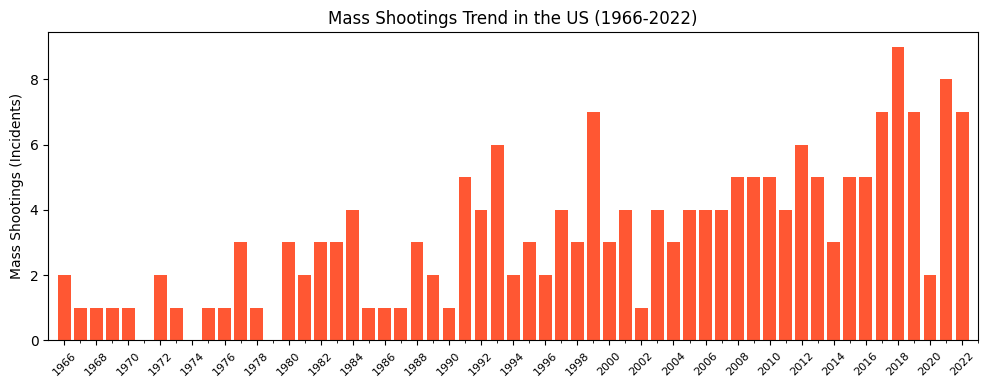

In [9]:
# Set the figure size
fig, ax = plt.subplots(figsize=(12,4))

# Create a bar chart using pyplot.bar()
ax.bar(trend_df["_id"], trend_df["mass_shootings"], color='#FF5733')

# Set the x-limits to exclude empty spaces
ax.set_xlim(left=-1, right=len(trend_df["_id"])+0)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Set the x-tick frequency to only show even years
ax.set_xticks(trend_df.index[trend_df["_id"].astype(int) % 2 == 0])
ax.set_xticklabels(trend_df["_id"][trend_df["_id"].astype(int) % 2 == 0], fontsize=8)

# Add minor ticks
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))

# Add labels and title to the chart
ax.set_ylabel('Mass Shootings (Incidents)')
ax.set_title('Mass Shootings Trend in the US (1966-2022)')

# full_DB visualization

In [10]:
# Create the database under 'project3'
full_db = mongo['project3']

In [11]:
# Create the database under 'project3'
full_db = mongo['project3']

# Print collection names
print(full_db.list_collection_names())

# Define the collection
full_collection = full_db['full_data']

['full_data']


In [29]:
pipeline = [
    {
        "$match": {
            "Mental Illness": {
                "$in": [0, 1, 2, 3, 4, "1, 2"]
            }
        }
    },
    {
        "$group": {
            "_id": "$Mental Illness",
            "count": {"$sum": 1}
        }
    }
]
results = list(full_collection.aggregate(pipeline))

In [13]:

# Create lists to store the labels and counts for the pie chart
labels = []
counts = []

# Iterate through the results and append the labels and counts to the corresponding lists
for result in results:
    labels.append(result['_id'])
    counts.append(result['count'])

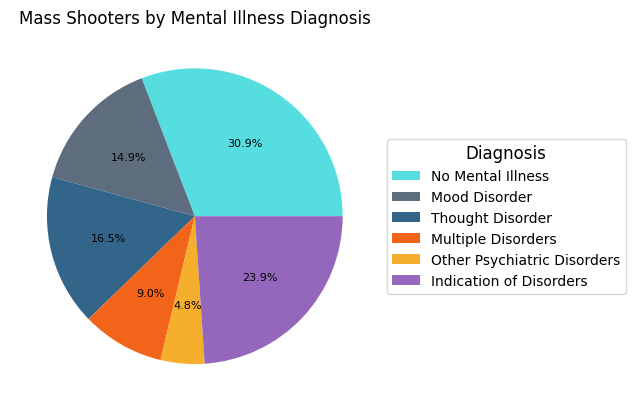

In [14]:
# Define a dictionary to map the current labels to the desired labels and colors
label_map = {
    0: {"label": "No Mental Illness", "color": "#55DDE0"},
    1: {"label": "Mood Disorder", "color": "#5D6D7E"},
    2: {"label": "Thought Disorder", "color": "#33658A"},
    3: {"label": "Other Psychiatric Disorders", "color": "#F6AE2D"},
    4: {"label": "Indication of Disorders", "color": "#9467bd"},
    "1, 2": {"label": "Multiple Disorders", "color": "#F26419"}
}

# Define the desired order of the labels for the legend
legend_order = [
    "No Mental Illness",
    "Mood Disorder",
    "Thought Disorder",
    "Multiple Disorders",
    "Other Psychiatric Disorders",
    "Indication of Disorders"
]

# Create lists to store the labels and counts for the pie chart
labels = []
counts = []
colors = []

# Iterate through the results and append the labels, counts, and colors to the corresponding lists
for label in legend_order:
    for result in results:
        if label_map[result['_id']]['label'] == label:
            label_info = label_map[result['_id']]
            labels.append(label_info['label'])
            counts.append(result['count'])
            colors.append(label_info['color'])
            break
    
# Create the pie chart with the new colors
plt.pie(counts, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 8})
plt.title('Mass Shooters by Mental Illness Diagnosis')
legend = plt.legend(labels, title="Diagnosis", loc='center left', bbox_to_anchor=(1, 0.5))
legend.get_title().set_fontsize('12')
plt.show()

In [15]:
fatal_columns = {'City': 1, 'State': 1, 'Year': 1, 'Number Killed': 1, '_id': 0}

In [16]:
# Query the collection and retrieve the data
cursor = full_collection.find({}, fatal_columns)
data = list(cursor)

# Create a dataframe from the retrieved data
fatal_df = pd.DataFrame(data)
top_fatal_df =fatal_df.sort_values(by='Number Killed', ascending=False).head(5)

top_fatal_df

,Year,City,State,Number Killed
152,2017,Las Vegas�,NV,60
145,2016,Orlando�,FL,49
101,2007,Blacksburg,VA,32
128,2012,Sandy Hook,CT,27
147,2017,Sutherland Springs,TX,25


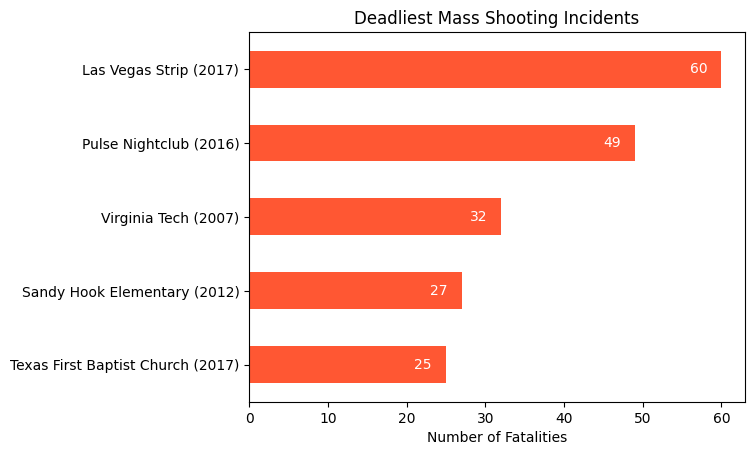

In [17]:
# Sort the dataframe in descending order based on "Number Killed"
top_fatal_df = top_fatal_df.sort_values(by='Number Killed', ascending=True)

# Create the horizontal bar plot
ax = top_fatal_df.plot(kind='barh', x='City', y='Number Killed', color='#FF5733', legend=False)

# Set the custom tick labels for the x-axis
ax.set_yticklabels(['Texas First Baptist Church (2017)', 'Sandy Hook Elementary (2012)', 'Virginia Tech (2007)', 'Pulse Nightclub (2016)', 'Las Vegas Strip (2017)'])

# Set the title and axis labels
plt.title('Deadliest Mass Shooting Incidents')
plt.xlabel('Number of Fatalities')
plt.ylabel('')

# Add text inside each bar to display the value of "Number Killed"
for i, v in enumerate(top_fatal_df['Number Killed']):
    ax.text(v - 4, i, str(v), color='white', va='center')

# Show the plot
plt.show()


In [51]:
# Define columns to be retrieved
motive_columns = ["Motive: Racism/Xenophobia",
    "Motive: Religious Hate",
    "Motive: Misogyny",
    "Motive: Homophobia",
    "Motive: Employment Issue",
    "Motive: Economic Issue",
    "Motive: Legal Issue",
    "Motive: Relationship Issue",
    "Motive: Fame-Seeking",
    "Motive: Unknown",
    "Year"]

# Retrieve data from collection
motive_data = full_collection.find({}, motive_columns)

# Create dataframe
motive_df = pd.DataFrame(list(motive_data))
# Drop the _id column
motive_df = motive_df.drop('_id', axis=1)
motive_df

,Year,Motive: Racism/Xenophobia,Motive: Religious Hate,Motive: Misogyny,Motive: Homophobia,Motive: Employment Issue,Motive: Economic Issue,Motive: Legal Issue,Motive: Relationship Issue,Motive: Fame-Seeking,Motive: Unknown
0,1966,0,0,0,0,0,0,0,0,0,1
1,1966,0,0,1,0,0,0,0,0,1,0
2,1967,0,0,0,0,0,0,0,0,0,0
3,1968,0,0,0,0,0,0,0,1,0,0
4,1969,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
184,2022,,,,,,,,,,1
185,2022,1,1,0,0,0,0,0,0,0,0
186,2022,0,0,0,0,0,0,0,0,0,1
187,2022,0,0,0,0,0,0,0,0,0,0


In [37]:
print(motive_df.columns)

Index(['Year', 'Motive: Racism/Xenophobia', 'Motive: Religious Hate',
       'Motive: Misogyny', 'Motive: Homophobia', 'Motive: Employment Issue',
       'Motive: Economic Issue', 'Motive: Legal Issue',
       'Motive: Relationship Issue', 'Motive: Fame-Seeking',
       'Motive: Unknown'],
      dtype='object')


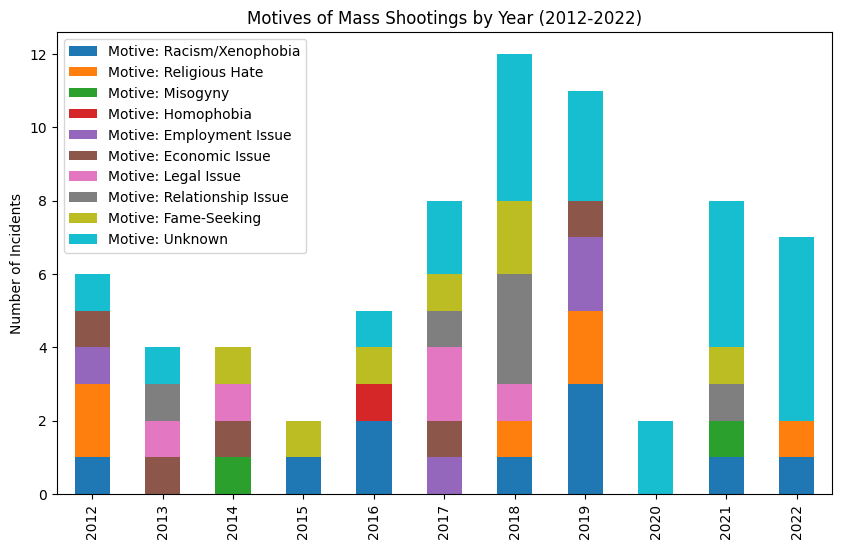

In [38]:
# Convert motive columns to numeric
motive_df[motive_columns[:-1]] = motive_df[motive_columns[:-1]].apply(pd.to_numeric)


# Group data by year and sum motive columns
motive_df = motive_df.groupby('Year')[motive_columns[:-1]].sum()

# Select rows where Year is greater than or equal to 2012
motive_df = motive_df[motive_df.index >= 2012]

# Create stacked bar plot
motive_df.plot(kind='bar', stacked=True, figsize=(10,6))

# Set the title and axis labels
plt.title('Motives of Mass Shootings by Year (2012-2022)')
plt.xlabel('')
plt.ylabel('Number of Incidents')

# Show the plot
plt.show()

KeyError: 'id'